# Load dataset and EDA


Import library

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import nltk
import logging
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from transformers import TFBertModel
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from transformers import BertTokenizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Read the dataset and see the top 5 row in the dataset

In [ ]:
df = pd.read_csv("hf://datasets/UniqueData/customers-reviews-on-banks/Banks.csv")
df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,author,date,location,bank,star,text,like
0,Kyle,31.08.2023,"Magnolia, TX",merrick_bank,5,Very easy to use to view statements and make o...,NaN
1,Julicia,23.08.2023,"Columbus, GA",merrick_bank,5,Merrick Bank has always been good to me for bu...,NaN
2,Karen,2.06.2023,"Marrero, LA",merrick_bank,4,Times are tough for everyone and I have worked...,3.0
3,Brent,29.03.2023,"Moultrie, GA",merrick_bank,5,I can not asked for a better Credit Card Compa...,3.0
4,Sharon,23.11.2022,"Burnham, IL",merrick_bank,5,Updated on 02/10/2023: I was happy to sign for...,3.0


Visualizing the star (rating) distribution from the dataset

/tmp/ipython-input-2918444330.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='star', data=df, palette='viridis')


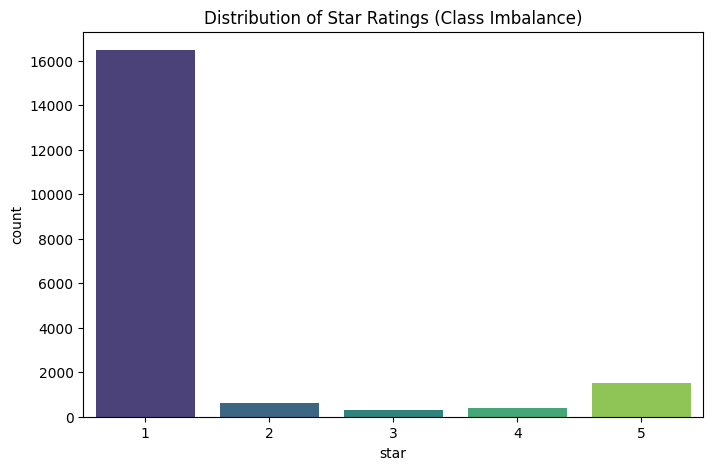

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='star', data=df, palette='viridis')
plt.title('Distribution of Star Ratings (Class Imbalance)')
plt.show()

Showing the sum of each star (rating)

In [ ]:
print(df['star'].value_counts())

star
1    16476
5     1501
2      629
4      373
3      292
Name: count, dtype: int64


Showing the information about our dataset, we can see that some column have missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19271 entries, 0 to 19270
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   author    19269 non-null  object 
 1   date      19271 non-null  object 
 2   location  19271 non-null  object 
 3   bank      19271 non-null  object 
 4   star      19271 non-null  int64  
 5   text      19181 non-null  object 
 6   like      17769 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


# Preprocess and split

Remove empty rows based on the 'text' column, then reset the index to tidy up the data

In [ ]:
df.dropna(subset=['text'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19181 entries, 0 to 19180
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   author    19179 non-null  object 
 1   date      19181 non-null  object 
 2   location  19181 non-null  object 
 3   bank      19181 non-null  object 
 4   star      19181 non-null  int64  
 5   text      19181 non-null  object 
 6   like      17685 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.0+ MB


Perform a train-test split on the data, designating the 'text' column as the input (x) and the 'star' column as the target (y)

In [ ]:
x = df['text']
y = df['star']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=19)

In the previous .head() output, we observed that the 5th row contains the phrase 'Updated on...', which will be removed during the preprocessing stage. We will also remove specific patterns like 'Updated on...', strip single quotes ('), convert all text to lowercase, and eliminate all punctuation and numbers to retain only alphabetic characters. Additionally, we will trim any excess whitespace. Once the cleansing is complete, we will proceed with tokenization, stopword removal, and lemmatization.

In [ ]:
print(x.head())

0    Very easy to use to view statements and make o...
1    Merrick Bank has always been good to me for bu...
2    Times are tough for everyone and I have worked...
3    I can not asked for a better Credit Card Compa...
4    Updated on 02/10/2023: I was happy to sign for...
Name: text, dtype: object


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = re.sub(r'Updated on\s+\d{1,2}/\d{1,2}/\d{4}:?', '', text, flags=re.IGNORECASE)
    text = text.replace("'", "")
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    clean_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    output = " ".join(clean_text)

    return output

Applying the preprocessing steps to the previously split training and testing datasets and showing the top 5 data from our train dataset

In [ ]:
x_trainc = x_train.apply(preprocess)
x_testc = x_test.apply(preprocess)

In [ ]:
x_trainc.head()

,text
14519,im personal banker fact know service isnt met ...
11576,mortgage process horrible start finish never g...
17475,pc mastercard since issue one day april discov...
14463,received replacement card mail card soon expir...
10118,june opened month cd ally bank authorized achd...


We perform vectorization using the TF-IDF method to weigh each word, limiting the vocabulary to the top 5,000 features. We apply fit_transform to the training data so it will become our dictionary (learning baseline), while using only transform on the test data. This ensures feature consistency during modeling and prevents errors caused by vocabulary mismatches between the training and testing sets

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
x_traint = tfidf.fit_transform(x_trainc)
x_testt = tfidf.transform(x_testc)

# SVM

We initialize the SVM model on the imbalanced dataset. We then fit the model to the training data and store the predictions in the variable y_pred_svm. Finally, we evaluate the model's performance by generating a classification report

In [ ]:
svm_model_unweighted = SVC(kernel='linear', class_weight= None , random_state=19)
svm_model_unweighted.fit(x_traint, y_train)

y_pred_svm = svm_model_unweighted.predict(x_testt)
print("Unweighted SVM Results:")
print(classification_report(y_test, y_pred_svm))

Unweighted SVM Results:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96      3267
           2       0.00      0.00      0.00       120
           3       0.00      0.00      0.00        64
           4       1.00      0.01      0.02        90
           5       0.77      0.79      0.78       296

    accuracy                           0.91      3837
   macro avg       0.54      0.36      0.35      3837
weighted avg       0.87      0.91      0.88      3837



/home/hartono/projects/tf_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hartono/projects/tf_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hartono/projects/tf_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Perform SVM modeling using class weighting (balanced) to address data imbalance. As before, we will fit the model, generate predictions, and display the classification report

In [ ]:
svm_model_weighted = SVC(kernel='linear', class_weight='balanced' , random_state=19)
svm_model_weighted.fit(x_traint, y_train)

y_pred_svm = svm_model_weighted.predict(x_testt)
print("Weighted SVM Results:")
print(classification_report(y_test, y_pred_svm))

Weighted SVM Results:
              precision    recall  f1-score   support

           1       0.95      0.86      0.90      3267
           2       0.08      0.27      0.12       120
           3       0.11      0.11      0.11        64
           4       0.18      0.14      0.16        90
           5       0.68      0.77      0.72       296

    accuracy                           0.80      3837
   macro avg       0.40      0.43      0.40      3837
weighted avg       0.87      0.80      0.83      3837



Hyperparameter tuning using GridSearchCV for SVM model for both imbalanced and balanced dataset

Initialize the parameter for our svm model

In [ ]:
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

Training our SVM imbalanced model with the hyperparameter tuning, and the scoring is focused on f1_macro because we want the model to perform sentiment analysis, which needs to be fair

In [ ]:
grid_svm_imb = GridSearchCV(
    SVC(),
    param_grid_svm,
    refit=True,
    verbose=1,
    cv=3,
    scoring='f1_macro'
)

grid_svm_imb.fit(x_traint, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.001, 0.01, ...], 'kernel': ['linear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate para

Evaluating the results of our hyperparameter tuning for SVM imbalanced data

In [ ]:
print(f"Parameter Terbaik: {grid_svm_imb.best_params_}")
y_pred_imb = grid_svm_imb.predict(x_testt)
print(classification_report(y_test, y_pred_imb))

Parameter Terbaik: {'C': 100, 'kernel': 'linear'}
              precision    recall  f1-score   support

           1       0.94      0.95      0.94      3267
           2       0.09      0.12      0.10       120
           3       0.10      0.05      0.06        64
           4       0.26      0.16      0.20        90
           5       0.73      0.73      0.73       296

    accuracy                           0.87      3837
   macro avg       0.42      0.40      0.41      3837
weighted avg       0.86      0.87      0.87      3837



Training our SVM balanced model with the hyperparameter tuning

In [ ]:
grid_svm_bal = GridSearchCV(
    SVC(class_weight='balanced'),
    param_grid_svm,
    refit=True,
    verbose=1,
    cv=3,
    scoring='f1_macro'
)

grid_svm_bal.fit(x_traint, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_weight='balanced')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.001, 0.01, ...], 'kernel': ['linear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the 

In [ ]:
print(f"Parameter Terbaik: {grid_svm_bal.best_params_}")
y_pred_bal = grid_svm_bal.predict(x_testt)
print(classification_report(y_test, y_pred_bal))

Parameter Terbaik: {'C': 1, 'kernel': 'linear'}
              precision    recall  f1-score   support

           1       0.95      0.86      0.90      3267
           2       0.08      0.27      0.12       120
           3       0.11      0.11      0.11        64
           4       0.18      0.14      0.16        90
           5       0.68      0.77      0.72       296

    accuracy                           0.80      3837
   macro avg       0.40      0.43      0.40      3837
weighted avg       0.87      0.80      0.83      3837



# LSTM

Convert X_train into a dense array. Maintaining the 5,000-feature limit from TF-IDF, we restructure the data into a 100x50 format. Subsequently, we reshape the input into a 3D tensor compatible with LSTM models and inspect the first sample.

In [ ]:
x_train_t_LSTM = x_traint.toarray()
x_test_t_LSTM = x_testt.toarray()

timesteps = 100
features = 50

x_train_LSTM = x_train_t_LSTM.reshape(len(x_train_t_LSTM), timesteps, features)
x_test_LSTM = x_test_t_LSTM.reshape(len(x_test_t_LSTM), timesteps, features)
x_train_LSTM[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.04024161],
       [0.08014552, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Converting the target variable "star" into integers and encode them using LabelEncoder. This transforms ratings 1-5 into class which range from 0-4

In [ ]:
y_train_LSTM = y_train.astype(int).to_numpy()
y_test_LSTM = y_test.astype(int).to_numpy()
labelEncoder = LabelEncoder()
y_train_LSTM_encoded = labelEncoder.fit_transform(y_train_LSTM)
y_test_LSTM_encoded = labelEncoder.transform(y_test_LSTM)
y_train_LSTM_encoded

array([0, 0, 0, ..., 0, 0, 0])

Make a sequential model which will be a LSTM layer with the shape that we define before, 30% dropout to prevent overfitting, a hidden layer and output layer with softmax for probability distribution. Lastly we will compile the model

In [ ]:
model_lstm = Sequential([
    LSTM(64, input_shape=(timesteps, features)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Making a callback which will have an earlystop function and also val_loss reduction if the result is redundant, and we will fit the model with our data

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

model_lstm.fit(
    x_train_LSTM, y_train_LSTM_encoded,
    validation_split=0.2,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
384/384 [==============================] - 19s 26ms/step - loss: 0.6333 - accuracy: 0.8522 - val_loss: 0.5725 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 2/50
384/384 [==============================] - 6s 17ms/step - loss: 0.5907 - accuracy: 0.8551 - val_loss: 0.5721 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 3/50
384/384 [==============================] - 6s 17ms/step - loss: 0.5910 - accuracy: 0.8551 - val_loss: 0.5831 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 4/50
384/384 [==============================] - 7s 18ms/step - loss: 0.5843 - accuracy: 0.8551 - val_loss: 0.5718 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 5/50
384/384 [==============================] - 7s 18ms/step - loss: 0.5827 - accuracy: 0.8551 - val_loss: 0.5688 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 6/50
384/384 [==============================] - 7s 19ms/step - loss: 0.5783 - accuracy: 0.8551 - val_loss: 0.5750 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 7/50
384/384 [==============================] - 6s 17ms/s

Evaluating the result, first the model will predict our data, and we will convert the prediction to class labels which is 0-4. Lastly we will show the classification report

In [ ]:
y_pred_prob = model_lstm.predict(x_test_LSTM)
y_pred = np.argmax(y_pred_prob, axis=1)
print(classification_report(y_test_LSTM_encoded, y_pred))

120/120 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3267
           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        90
           4       0.64      0.64      0.64       296

    accuracy                           0.89      3837
   macro avg       0.31      0.33      0.32      3837
weighted avg       0.83      0.89      0.86      3837



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


First we will identify the labels, after that we will compute the weight based on each of the labels and store it inside a dictionary

In [ ]:
classes = np.unique(y_train_LSTM_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_LSTM_encoded)
class_weights_dict = dict(zip(classes, weights))
class_weights_dict

{np.int64(0): np.float64(0.2337064960779834),
 np.int64(1): np.float64(6.1009940357852885),
 np.int64(2): np.float64(13.518942731277534),
 np.int64(3): np.float64(10.8822695035461),
 np.int64(4): np.float64(2.555203996669442)}

We will make the model like last time, and compile it but the difference is when we're performing fit to the model, because this time we will use the weights to make the data balanced

In [ ]:
model_lstm_weighted = Sequential([
    LSTM(64, input_shape=(timesteps, features)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

model_lstm_weighted.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_weighted.fit(
    x_train_LSTM, y_train_LSTM_encoded,
    validation_split=0.2,
    epochs=50,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

Epoch 1/50
384/384 [==============================] - 10s 21ms/step - loss: 1.6149 - accuracy: 0.0998 - val_loss: 1.5674 - val_accuracy: 0.0753 - lr: 0.0010
Epoch 2/50
384/384 [==============================] - 3s 8ms/step - loss: 1.6155 - accuracy: 0.0938 - val_loss: 1.5862 - val_accuracy: 0.4389 - lr: 0.0010
Epoch 3/50
384/384 [==============================] - 3s 8ms/step - loss: 1.6102 - accuracy: 0.2475 - val_loss: 1.5742 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 4/50
384/384 [==============================] - 4s 10ms/step - loss: 1.5803 - accuracy: 0.4596 - val_loss: 1.5219 - val_accuracy: 0.5226 - lr: 0.0010
Epoch 5/50
384/384 [==============================] - 3s 8ms/step - loss: 1.5290 - accuracy: 0.5599 - val_loss: 1.6255 - val_accuracy: 0.4298 - lr: 0.0010
Epoch 6/50
384/384 [==============================] - 3s 8ms/step - loss: 1.4972 - accuracy: 0.6120 - val_loss: 1.2645 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 7/50
384/384 [==============================] - 3s 8ms/step -

Evaluating the model by first making it to predict from our data and convert the prediction into our labels which is 0-4, and showing the classification report

In [ ]:
y_pred_prob_weighted = model_lstm_weighted.predict(x_test_LSTM)
y_pred_weighted = np.argmax(y_pred_prob_weighted, axis=1)
print(classification_report(y_test_LSTM_encoded, y_pred_weighted))

120/120 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      3267
           1       0.05      0.06      0.05       120
           2       0.01      0.02      0.01        64
           3       0.08      0.47      0.14        90
           4       0.51      0.23      0.32       296

    accuracy                           0.74      3837
   macro avg       0.32      0.32      0.28      3837
weighted avg       0.84      0.74      0.78      3837



Setting up some parameter for out parameter tuning in LSTM model

In [ ]:
lstm_units = [32, 64]
dropout_rates = [0.2, 0.5]

Building the LSTM model again but with the tuning

In [ ]:
def build_lstm_tuning(units, dropout_rate):
    model = Sequential()
    model.add(LSTM(units, input_shape=(timesteps, features), dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Building the manual tuning for our LSTM model

In [ ]:
def tune_lstm(is_balanced=False):
    best_loss = 99.0
    best_cfg = {}
    cw = class_weights_dict if is_balanced else None
    mode_name = "BALANCED" if is_balanced else "IMBALANCED"

    print(f"Tuning LSTM {mode_name}")

    for u in lstm_units:
        for d in dropout_rates:
            model = build_lstm_tuning(u, d)

            hist = model.fit(x_train_LSTM, y_train_LSTM_encoded, epochs=2,
                             validation_split=0.2, class_weight=cw, callbacks=callbacks, verbose=0)

            val_loss = hist.history['val_loss'][-1]
            print(f"Val Loss: {val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                best_cfg = {'units': u, 'dropout': d}

    print(f"Best {mode_name}: {best_cfg} (Acc: {best_loss:.4f})")
    return best_cfg

Performing the tuning and saving the results in a variable

In [ ]:
best_lstm_imb_params = tune_lstm(is_balanced=False)
best_lstm_bal_params = tune_lstm(is_balanced=True)

Tuning LSTM IMBALANCED


Val Loss: 0.5727


Val Loss: 0.5758


Val Loss: 0.5726


Val Loss: 0.5752
Best IMBALANCED: {'units': 64, 'dropout': 0.2} (Acc: 0.5726)
Tuning LSTM BALANCED


Val Loss: 1.6887


Val Loss: 1.6119


Val Loss: 1.5032
Val Loss: 1.6049
Best BALANCED: {'units': 64, 'dropout': 0.2} (Acc: 1.5032)


Training our imbalanced model with the best parameter

In [ ]:
final_lstm_imb = build_lstm_tuning(best_lstm_imb_params['units'], best_lstm_imb_params['dropout'])
final_lstm_imb.fit(x_train_LSTM, y_train_LSTM_encoded, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks, verbose=1)

Epoch 1/20
96/96 [==============================] - 29s 269ms/step - loss: 0.7493 - accuracy: 0.8477 - val_loss: 0.5742 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 2/20
96/96 [==============================] - 25s 265ms/step - loss: 0.5923 - accuracy: 0.8551 - val_loss: 0.5737 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 3/20
96/96 [==============================] - 25s 264ms/step - loss: 0.5891 - accuracy: 0.8551 - val_loss: 0.5757 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 4/20
96/96 [==============================] - 25s 259ms/step - loss: 0.5885 - accuracy: 0.8551 - val_loss: 0.5719 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 5/20
96/96 [==============================] - 25s 262ms/step - loss: 0.5885 - accuracy: 0.8551 - val_loss: 0.5728 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 6/20
96/96 [==============================] - 25s 262ms/step - loss: 0.5870 - accuracy: 0.8551 - val_loss: 0.5716 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 7/20
96/96 [==============================] - 26s 270ms/st

Evaluating the results for our imbalanced model

In [ ]:
y_pred = np.argmax(final_lstm_imb.predict(x_test_LSTM), axis=1)
print(classification_report(y_test_LSTM_encoded, y_pred))

120/120 [==============================] - 4s 30ms/step
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      3267
           1       0.00      0.00      0.00       120
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        90
           4       0.62      0.40      0.49       296

    accuracy                           0.87      3837
   macro avg       0.30      0.28      0.28      3837
weighted avg       0.80      0.87      0.83      3837



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Training our balanced model with the best parameter

In [ ]:
final_lstm_bal = build_lstm_tuning(best_lstm_bal_params['units'], best_lstm_bal_params['dropout'])
final_lstm_bal.fit(x_train_LSTM, y_train_LSTM_encoded, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks, class_weight=class_weights_dict, verbose=1)

Epoch 1/20
96/96 [==============================] - 29s 266ms/step - loss: 1.6148 - accuracy: 0.1633 - val_loss: 1.5934 - val_accuracy: 0.0150 - lr: 0.0010
Epoch 2/20
96/96 [==============================] - 25s 261ms/step - loss: 1.6144 - accuracy: 0.0743 - val_loss: 1.6086 - val_accuracy: 0.0407 - lr: 0.0010
Epoch 3/20
96/96 [==============================] - 25s 257ms/step - loss: 1.6113 - accuracy: 0.2860 - val_loss: 1.6125 - val_accuracy: 0.1245 - lr: 0.0010
Epoch 4/20
96/96 [==============================] - 25s 257ms/step - loss: 1.6103 - accuracy: 0.5498 - val_loss: 1.5427 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 5/20
96/96 [==============================] - 25s 257ms/step - loss: 1.6046 - accuracy: 0.4889 - val_loss: 1.5449 - val_accuracy: 0.2401 - lr: 0.0010
Epoch 6/20
96/96 [==============================] - 25s 258ms/step - loss: 1.5908 - accuracy: 0.4084 - val_loss: 1.5918 - val_accuracy: 0.3177 - lr: 0.0010
Epoch 7/20
96/96 [==============================] - 25s 262ms/st

Evaluating the results for our imbalanced model

In [ ]:
y_pred_b = np.argmax(final_lstm_bal.predict(x_test_LSTM), axis=1)
print(classification_report(y_test_LSTM_encoded, y_pred_b))

120/120 [==============================] - 4s 29ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      3267
           1       0.06      0.01      0.01       120
           2       0.02      0.03      0.02        64
           3       0.10      0.42      0.17        90
           4       0.59      0.10      0.17       296

    accuracy                           0.80      3837
   macro avg       0.34      0.30      0.26      3837
weighted avg       0.82      0.80      0.79      3837



# BERT

For the BERT model, we performed only basic data cleansing, excluding tokenization, lemmatization, and stop word removal

In [ ]:
def minimal_clean(text):
    text = re.sub(r'Updated on\s+\d{1,2}/\d{1,2}/\d{4}:?', '', text, flags=re.IGNORECASE)
    text = text.replace("'", "")
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

Performing train test split and then applying the cleansing function to our train and test data

In [ ]:
xb = df['text']
yb = df['star'] - 1

In [ ]:
x_trainb, x_testb, y_trainb, y_testb = train_test_split(xb, yb, test_size=0.2, random_state=19)

In [ ]:
x_trainb = x_trainb.apply(minimal_clean)
x_testb = x_testb.apply(minimal_clean)

We created a tokenizer and set mlen to truncate tokens to that specific length. Then, we created a function that takes the data and maximum length as inputs. We also prepared two lists: input_ids to store the token IDs (numbers representing words) and attention_masks to store the masks (1 for real tokens, 0 for padding) and performing the tokenizer to our train and test data

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlen = 128

def bert_token(data, maximum_length):
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length',
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

train_input_ids, train_attention_masks = bert_token(x_trainb, mlen)
test_input_ids, test_attention_masks = bert_token(x_testb, mlen)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In this code we're making a function to construct the fine-tuned BERT model. We use the pre-trained bert-base-uncased model as the primary encoder, adding a custom classification head with Dropout and Dense layers to predict sentiment across five specific ratings.

In [ ]:
bert_base = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)

def create_bert_model(bert_model):
    input_ids = tf.keras.Input(shape=(mlen,), dtype='int32', name='input_ids')
    attention_masks = tf.keras.Input(shape=(mlen,), dtype='int32', name='attention_masks')

    embeddings = bert_model(input_ids, attention_mask=attention_masks)[1]

    x = tf.keras.layers.Dropout(0.3)(embeddings)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Al

Perform training for our bert model, in this case it's the imbalance data

In [ ]:
model_imb = create_bert_model(bert_base)
model_imb.fit(
    [train_input_ids, train_attention_masks],
    y_trainb,
    validation_split=0.2,
    epochs=2,
    batch_size=16,
    verbose=1
)

Epoch 1/2
768/768 [==============================] - 445s 504ms/step - loss: 0.3901 - accuracy: 0.9053 - val_loss: 0.3146 - val_accuracy: 0.9195
Epoch 2/2
768/768 [==============================] - 340s 442ms/step - loss: 0.2887 - accuracy: 0.9264 - val_loss: 0.2958 - val_accuracy: 0.9211


Evaluating the model and printing out the classification report

In [ ]:
pred_probs = model_imb.predict([test_input_ids, test_attention_masks])
y_pred = np.argmax(pred_probs, axis=1)
target_names = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
print(classification_report(y_testb, y_pred, target_names=target_names))

120/120 [==============================] - 34s 266ms/step
              precision    recall  f1-score   support

      1 Star       0.93      1.00      0.96      3267
     2 Stars       0.00      0.00      0.00       120
     3 Stars       0.00      0.00      0.00        64
     4 Stars       0.60      0.10      0.17        90
     5 Stars       0.76      0.86      0.81       296

    accuracy                           0.92      3837
   macro avg       0.46      0.39      0.39      3837
weighted avg       0.87      0.92      0.89      3837



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Making the balanced dataset using the weight method

In [ ]:
classes = np.unique(y_trainb)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_trainb)
class_weights_dict = dict(zip(classes, weights))

Training the model again, this time we're using the balanced dataset

In [ ]:
model_bal = create_bert_model(bert_base)
model_bal.fit(
    [train_input_ids, train_attention_masks],
    y_trainb,
    validation_split=0.2,
    epochs=2,
    batch_size=16,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/2
768/768 [==============================] - 399s 455ms/step - loss: 1.1598 - accuracy: 0.6921 - val_loss: 0.5833 - val_accuracy: 0.8433
Epoch 2/2
768/768 [==============================] - 340s 443ms/step - loss: 0.9546 - accuracy: 0.7012 - val_loss: 0.7585 - val_accuracy: 0.7110


Evaluating the model and printing out the classification report

In [ ]:
pred_probs_bal = model_bal.predict([test_input_ids, test_attention_masks])
y_pred_bal = np.argmax(pred_probs_bal, axis=1)
print(classification_report(y_testb, y_pred_bal, target_names=target_names))

120/120 [==============================] - 35s 266ms/step
              precision    recall  f1-score   support

      1 Star       0.98      0.73      0.84      3267
     2 Stars       0.06      0.43      0.11       120
     3 Stars       0.13      0.30      0.19        64
     4 Stars       0.29      0.36      0.32        90
     5 Stars       0.81      0.86      0.83       296

    accuracy                           0.71      3837
   macro avg       0.46      0.53      0.46      3837
weighted avg       0.91      0.71      0.79      3837



Setting our variable for the parameter tuning, in BERT we're only focusing on the Learning Rate

In [ ]:
lr_options = [2e-5, 3e-5, 5e-5]

Building our bert model, the difference here is only at the optimizer which will have the value of our variable we set earlier

In [ ]:
def build_bert_custom(learning_rate):
    input_ids = tf.keras.Input(shape=(mlen,), dtype='int32', name='input_ids')
    attention_masks = tf.keras.Input(shape=(mlen,), dtype='int32', name='attention_masks')

    embeddings = bert_base(input_ids, attention_mask=attention_masks)[1]

    x = tf.keras.layers.Dropout(0.3)(embeddings)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    output = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

Building the tuning function where it will return the best Learning Rate value for both balanced and imbalanced data

In [ ]:
def tune_bert(is_balanced=False):
    best_loss = 99.0
    best_lr = 2e-5
    cw = class_weights_dict if is_balanced else None
    mode = "BALANCED" if is_balanced else "IMBALANCED"

    print(f"Tuning BERT {mode}")

    for lr in lr_options:
        print(f"Testing Learning Rate: {lr}...", end=" ")
        model = build_bert_custom(lr)

        hist = model.fit(
            [train_input_ids, train_attention_masks], y_trainb,
            validation_split=0.2,
            epochs=2, batch_size=16, class_weight=cw, verbose=1
        )

        val_loss = hist.history['val_loss'][-1]
        print(f"Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_lr = lr

    print(f"Best {mode}: LR={best_lr}")
    return best_lr

Perform the tuning and saving the best Learning rate value in a variable

In [ ]:
best_lr_imb = tune_bert(is_balanced=False)
best_lr_bal = tune_bert(is_balanced=True)

Tuning BERT IMBALANCED
Testing Learning Rate: 2e-05... Epoch 1/2
768/768 [==============================] - 397s 453ms/step - loss: 0.2333 - accuracy: 0.9336 - val_loss: 0.3273 - val_accuracy: 0.9205
Epoch 2/2
768/768 [==============================] - 339s 442ms/step - loss: 0.1498 - accuracy: 0.9511 - val_loss: 0.4104 - val_accuracy: 0.9156
Val Loss: 0.4104
Testing Learning Rate: 3e-05... Epoch 1/2
768/768 [==============================] - 397s 454ms/step - loss: 0.1524 - accuracy: 0.9492 - val_loss: 0.4618 - val_accuracy: 0.9097
Epoch 2/2
768/768 [==============================] - 340s 442ms/step - loss: 0.1118 - accuracy: 0.9633 - val_loss: 0.4726 - val_accuracy: 0.8648
Val Loss: 0.4726
Testing Learning Rate: 5e-05... Epoch 1/2
768/768 [==============================] - 419s 481ms/step - loss: 0.1754 - accuracy: 0.9431 - val_loss: 0.5631 - val_accuracy: 0.8456
Epoch 2/2
768/768 [==============================] - 340s 442ms/step - loss: 0.1330 - accuracy: 0.9587 - val_loss: 0.4414 

Training the imbalanced model using the best learning rate value we found earlier in tuning

In [ ]:
final_bert_imb = build_bert_custom(best_lr_imb)
final_bert_imb.fit(
    [train_input_ids, train_attention_masks],
    y_trainb,
    validation_split=0.2,
    epochs=2,
    batch_size=16,
    verbose=1
)

Epoch 1/2
768/768 [==============================] - 401s 455ms/step - loss: 0.0998 - accuracy: 0.9725 - val_loss: 0.5667 - val_accuracy: 0.9084
Epoch 2/2
768/768 [==============================] - 341s 444ms/step - loss: 0.0281 - accuracy: 0.9933 - val_loss: 0.5743 - val_accuracy: 0.8987


Evaluating the result of our imbalanced model with the best learning rate

In [ ]:
pred_imb = final_bert_imb.predict([test_input_ids, test_attention_masks])
y_pred_bert_imb = np.argmax(pred_imb, axis=1)
print(classification_report(y_testb, y_pred_bert_imb, target_names=target_names))

120/120 [==============================] - 35s 266ms/step
              precision    recall  f1-score   support

      1 Star       0.95      0.97      0.96      3267
     2 Stars       0.12      0.07      0.09       120
     3 Stars       0.23      0.11      0.15        64
     4 Stars       0.41      0.21      0.28        90
     5 Stars       0.74      0.88      0.81       296

    accuracy                           0.90      3837
   macro avg       0.49      0.45      0.46      3837
weighted avg       0.88      0.90      0.89      3837



Training the balanced model using the best learning rate value we found earlier in tuning

In [ ]:
final_bert_bal = build_bert_custom(best_lr_bal)
final_bert_bal.fit(
    [train_input_ids, train_attention_masks],
    y_trainb,
    validation_split=0.2,
    epochs=2,
    batch_size=16,
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/2
768/768 [==============================] - 406s 455ms/step - loss: 0.2184 - accuracy: 0.9775 - val_loss: 0.6044 - val_accuracy: 0.8775
Epoch 2/2
768/768 [==============================] - 340s 443ms/step - loss: 0.2118 - accuracy: 0.9812 - val_loss: 0.4608 - val_accuracy: 0.9039


Evaluating the result of our balanced model with the best learning rate

In [ ]:
pred_bal = final_bert_bal.predict([test_input_ids, test_attention_masks])
y_pred_bert_bal = np.argmax(pred_bal, axis=1)
print(classification_report(y_testb, y_pred_bert_bal, target_names=target_names))

120/120 [==============================] - 35s 268ms/step
              precision    recall  f1-score   support

      1 Star       0.95      0.97      0.96      3267
     2 Stars       0.13      0.04      0.06       120
     3 Stars       0.21      0.14      0.17        64
     4 Stars       0.30      0.18      0.22        90
     5 Stars       0.75      0.85      0.80       296

    accuracy                           0.90      3837
   macro avg       0.47      0.44      0.44      3837
weighted avg       0.88      0.90      0.89      3837

